# Football YOLO Model Training

Training YOLOv8 for football ball and player detection

In [1]:
# Setup and imports
import torch
from ultralytics import YOLO
from pathlib import Path
import yaml
import cv2
import matplotlib.pyplot as plt
import random
from helpers.data_helpers import load_annotations, visualize_annotations

# Mac optimization - use MPS if available
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
PyTorch version: 2.3.1


In [2]:
# Setup dataset paths with absolute paths
DATA_DIR = Path('data').resolve()

# Create correct data.yaml with absolute paths
data_config = {
    'names': ['ball', 'goalkeeper', 'player', 'referee'],
    'nc': 4,
    'train': str(DATA_DIR / 'train' / 'images'),
    'val': str(DATA_DIR / 'valid' / 'images'),
    'test': str(DATA_DIR / 'test' / 'images')
}

# Save corrected data.yaml
with open(DATA_DIR / 'data.yaml', 'w') as f:
    yaml.dump(data_config, f)

class_names = data_config['names']
print(f"Classes: {class_names}")
print(f"Data paths updated with absolute paths")

# Count training data
train_images = list((DATA_DIR / 'train' / 'images').glob('*.jpg'))
val_images = list((DATA_DIR / 'valid' / 'images').glob('*.jpg'))
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Classes: ['ball', 'goalkeeper', 'player', 'referee']
Data paths updated with absolute paths
Training images: 612
Validation images: 38


Sample: 08fd33_0_3_png.rf.5dbf3adcb83605593f56252d4373c4f0.jpg - 20 objects


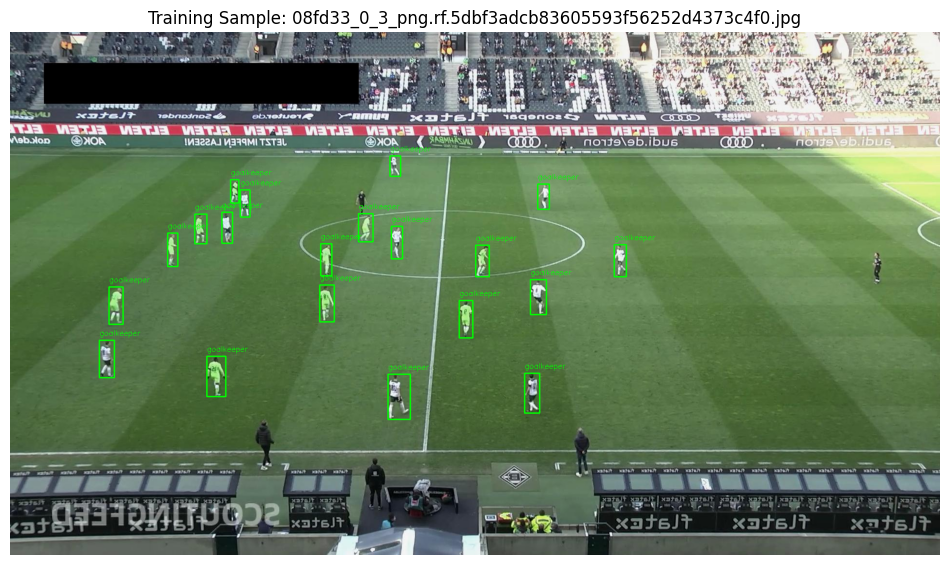

In [3]:
# Visualize sample data
sample_img = random.choice(train_images)
sample_label = DATA_DIR / 'train' / 'labels' / (sample_img.stem + '.txt')
annotations = load_annotations(sample_label)

print(f"Sample: {sample_img.name} - {len(annotations)} objects")
if annotations:
    visualize_annotations(sample_img, annotations, f"Training Sample: {sample_img.name}", class_names)

In [4]:
# Initialize YOLOv8 model
# YOLOv8n: 3.2M parameters, optimal for Mac training
model = YOLO('yolov8n.pt')  # Pretrained weights for transfer learning
print("Model loaded successfully")

Model loaded successfully


In [5]:
# Training configuration optimized for Mac
config = {
    'data': str(DATA_DIR / 'data.yaml'),
    'epochs': 50,      # Sufficient for convergence
    'imgsz': 640,      # Standard YOLO input size
    'batch': 16,       # Mac memory optimized
    'device': device,  # MPS acceleration on Mac
    'workers': 4,      # CPU cores for data loading
    'patience': 10,    # Early stopping
    'cache': True,     # Cache images in RAM
    'mixup': 0.1,      # Data augmentation for generalization
    'mosaic': 1.0,     # Improves small object (ball) detection
    'degrees': 10,     # Camera angle variations
    'translate': 0.1,  # Player movement
    'scale': 0.2,      # Distance variations
    'fliplr': 0.5,     # Field symmetry
    'flipud': 0.0,     # Maintain field orientation
    'hsv_h': 0.015,    # Lighting conditions
    'hsv_s': 0.7,      # Grass color variations
    'hsv_v': 0.4       # Shadow/sunlight
}

print("Training configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Training configuration:
  data: /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/data.yaml
  epochs: 50
  imgsz: 640
  batch: 16
  device: mps
  workers: 4
  patience: 10
  cache: True
  mixup: 0.1
  mosaic: 1.0
  degrees: 10
  translate: 0.1
  scale: 0.2
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4


In [6]:
# Train the model
print("Starting training...")
results = model.train(**config)
print("Training completed!")

Starting training...
New https://pypi.org/project/ultralytics/8.3.208 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=mps, workers=4, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

train: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/train/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
train: Caching images (0.4GB RAM): 100%|██████████| 612/612 [00:00<00:00, 995.45it/s] 
val: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 38/38 [00:00<00:00, 1085.62it/s]


Plotting labels to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.927      4.028     0.9923        563        640:  31%|███       | 12/39 [00:15<00:34,  1.29s/it]


KeyboardInterrupt: 

In [13]:
# Evaluate model
val_results = model.val()
print(f"Validation Results:")
print(f"  mAP@0.5: {val_results.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {val_results.box.map:.4f}")
print(f"  Precision: {val_results.box.mp:.4f}")
print(f"  Recall: {val_results.box.mr:.4f}")

Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 38/38 [00:00<00:00, 769.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:11<00:23, 11.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:16<00:07,  7.49s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.52s/it]


                   all         38        905      0.742      0.172       0.19      0.112
                  ball         35         35          1          0          0          0
            goalkeeper         27         27      0.594      0.259      0.261      0.146
                player         38        754      0.809      0.317      0.345      0.209
               referee         38         89      0.567      0.112      0.153     0.0938
Speed: 29.1ms preprocess, 343.4ms inference, 0.0ms loss, 248.6ms postprocess per image
Results saved to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train22
Validation Results:
  mAP@0.5: 0.1898
  mAP@0.5:0.95: 0.1122
  Precision: 0.7425
  Recall: 0.1721



WARNING ⚠️ NMS time limit 2.050s exceeded
image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/54745b_9_6_png.rf.9670b3ae25639828ce68a51f35ab0d95.jpg: 384x640 19 players, 8280.4ms
Speed: 98.7ms preprocess, 8280.4ms inference, 5182.3ms postprocess per image at shape (1, 3, 384, 640)

54745b_9_6_png.rf.9670b3ae25639828ce68a51f35ab0d95.jpg:
  Ground Truth: 24 objects
  Predicted: 19 objects
    player: 0.865
    player: 0.859
    player: 0.826
    player: 0.804
    player: 0.750
    player: 0.747
    player: 0.706
    player: 0.701
    player: 0.662
    player: 0.600
    player: 0.487
    player: 0.475
    player: 0.472
    player: 0.424
    player: 0.403
    player: 0.390
    player: 0.356
    player: 0.340
    player: 0.316
  Comparison (GT vs Pred):
    ball: 1 vs 0
    goalkeeper: 1 vs 0
    player: 20 vs 19
    referee: 2 vs 0


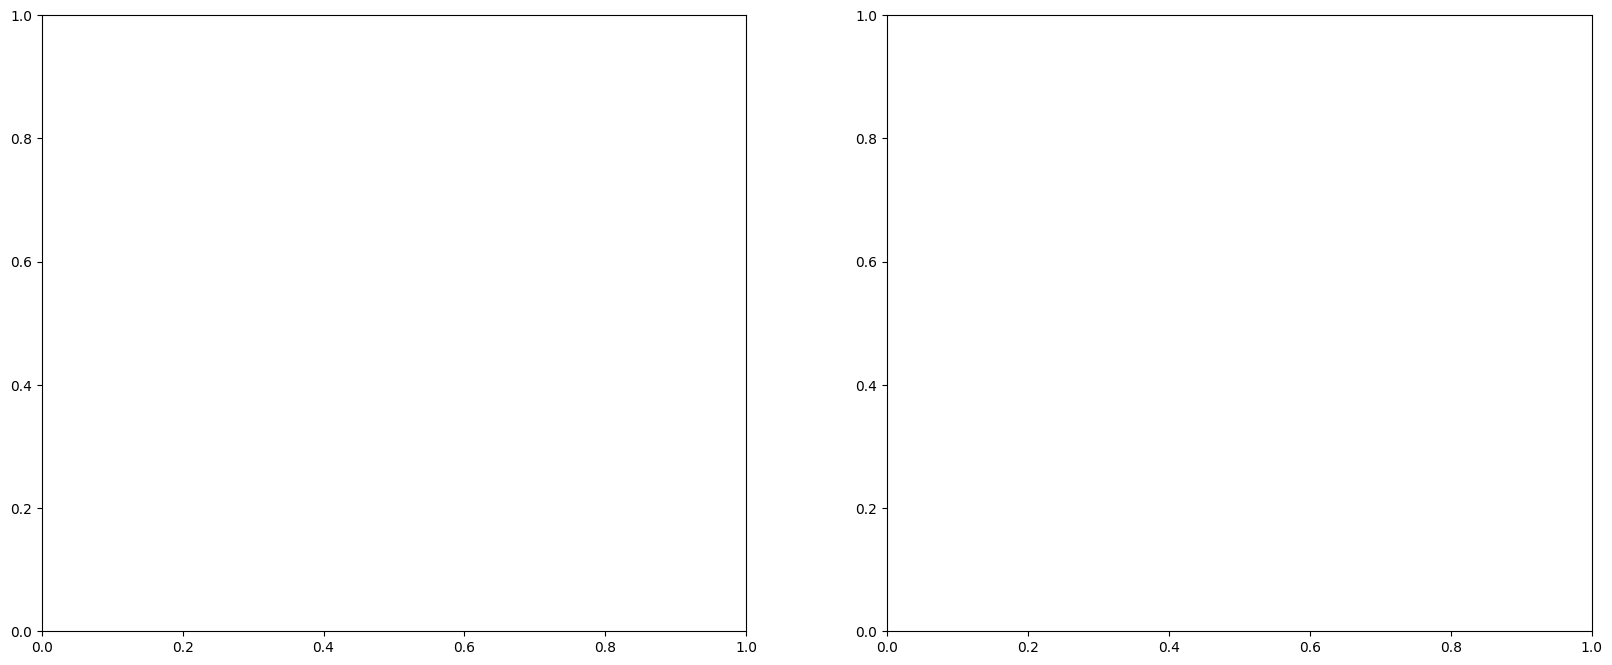

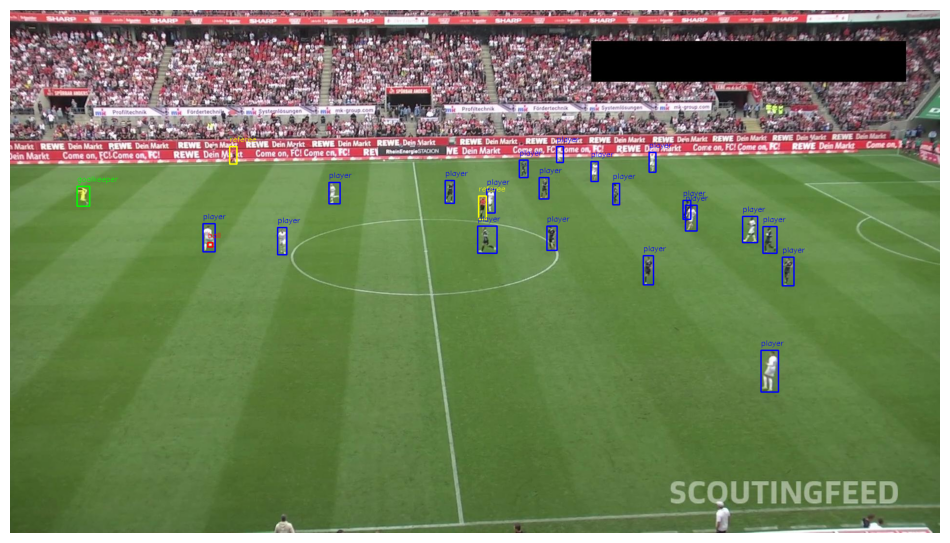

<Figure size 640x480 with 0 Axes>


image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/798b45_7_4_png.rf.7e95236908fb69555ee34e25ab14b662.jpg: 384x640 20 players, 562.2ms
Speed: 10.5ms preprocess, 562.2ms inference, 1701.4ms postprocess per image at shape (1, 3, 384, 640)

798b45_7_4_png.rf.7e95236908fb69555ee34e25ab14b662.jpg:
  Ground Truth: 24 objects
  Predicted: 20 objects
    player: 0.860
    player: 0.804
    player: 0.798
    player: 0.761
    player: 0.751
    player: 0.742
    player: 0.730
    player: 0.700
    player: 0.694
    player: 0.667
    player: 0.643
    player: 0.641
    player: 0.620
    player: 0.561
    player: 0.537
    player: 0.526
    player: 0.509
    player: 0.309
    player: 0.280
    player: 0.262
  Comparison (GT vs Pred):
    ball: 1 vs 0
    goalkeeper: 1 vs 0
    player: 21 vs 20
    referee: 1 vs 0


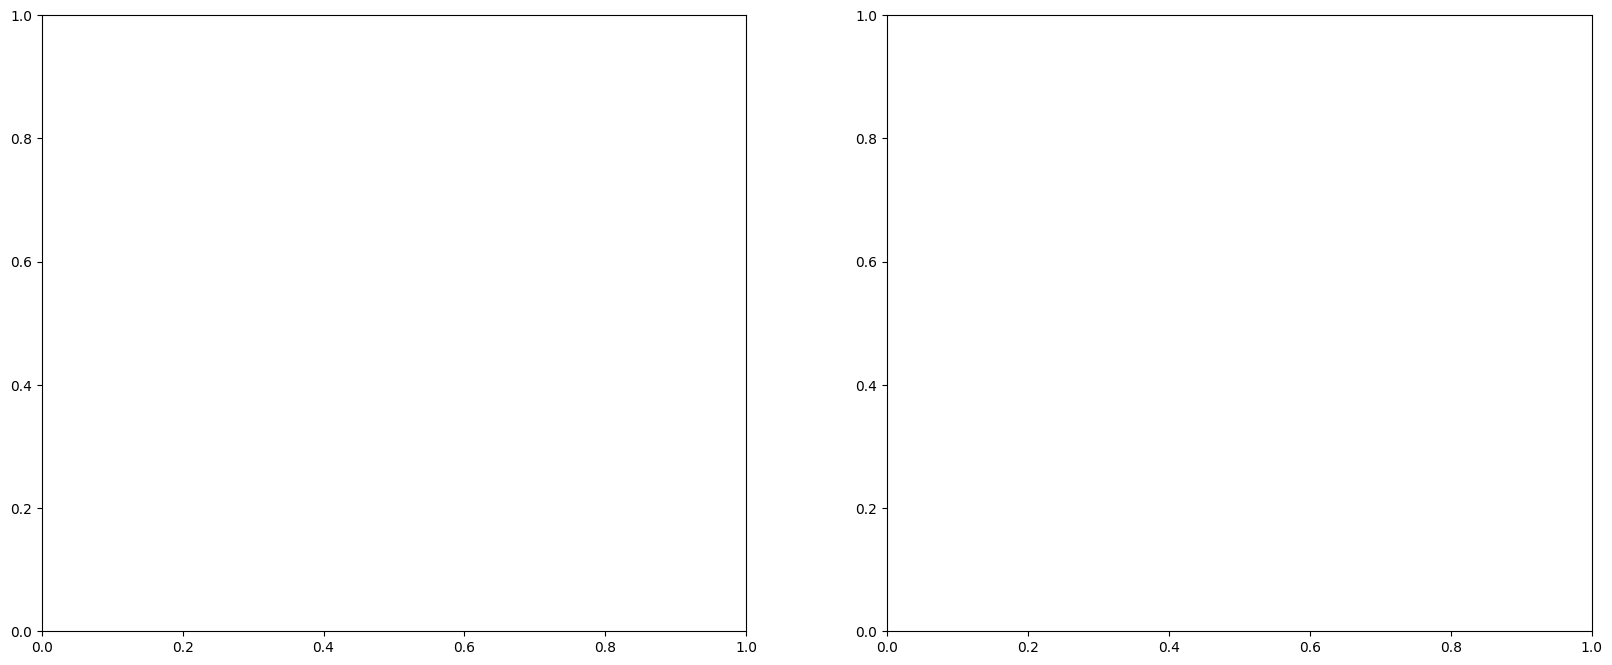

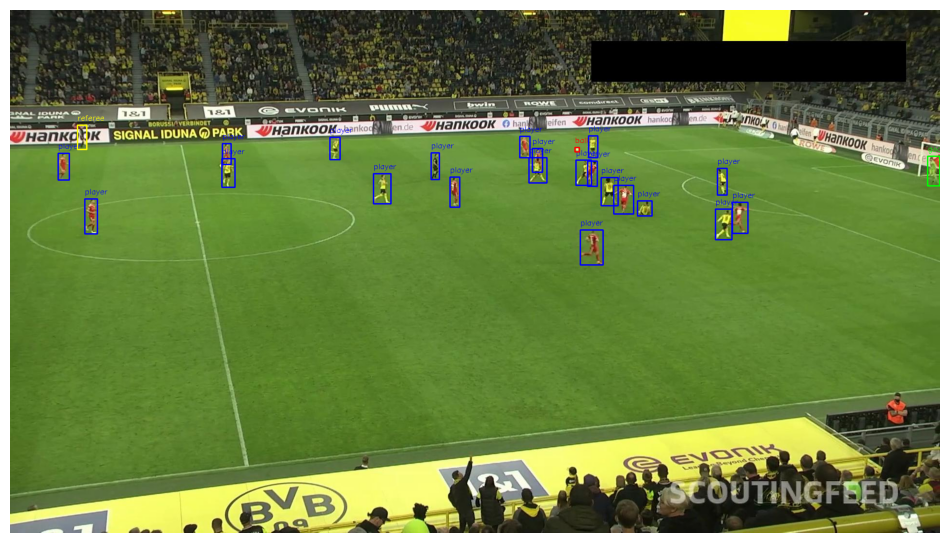

<Figure size 640x480 with 0 Axes>


image 1/1 /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/data/valid/images/744b27_1_7_png.rf.b2d05a9295c0da84bb0f7107fa0b44f5.jpg: 384x640 19 players, 786.9ms
Speed: 3.6ms preprocess, 786.9ms inference, 1285.0ms postprocess per image at shape (1, 3, 384, 640)

744b27_1_7_png.rf.b2d05a9295c0da84bb0f7107fa0b44f5.jpg:
  Ground Truth: 23 objects
  Predicted: 19 objects
    player: 0.866
    player: 0.799
    player: 0.774
    player: 0.772
    player: 0.761
    player: 0.754
    player: 0.749
    player: 0.736
    player: 0.714
    player: 0.628
    player: 0.602
    player: 0.582
    player: 0.568
    player: 0.550
    player: 0.504
    player: 0.482
    player: 0.383
    player: 0.318
    player: 0.270
  Comparison (GT vs Pred):
    ball: 1 vs 0
    player: 20 vs 19
    referee: 2 vs 0


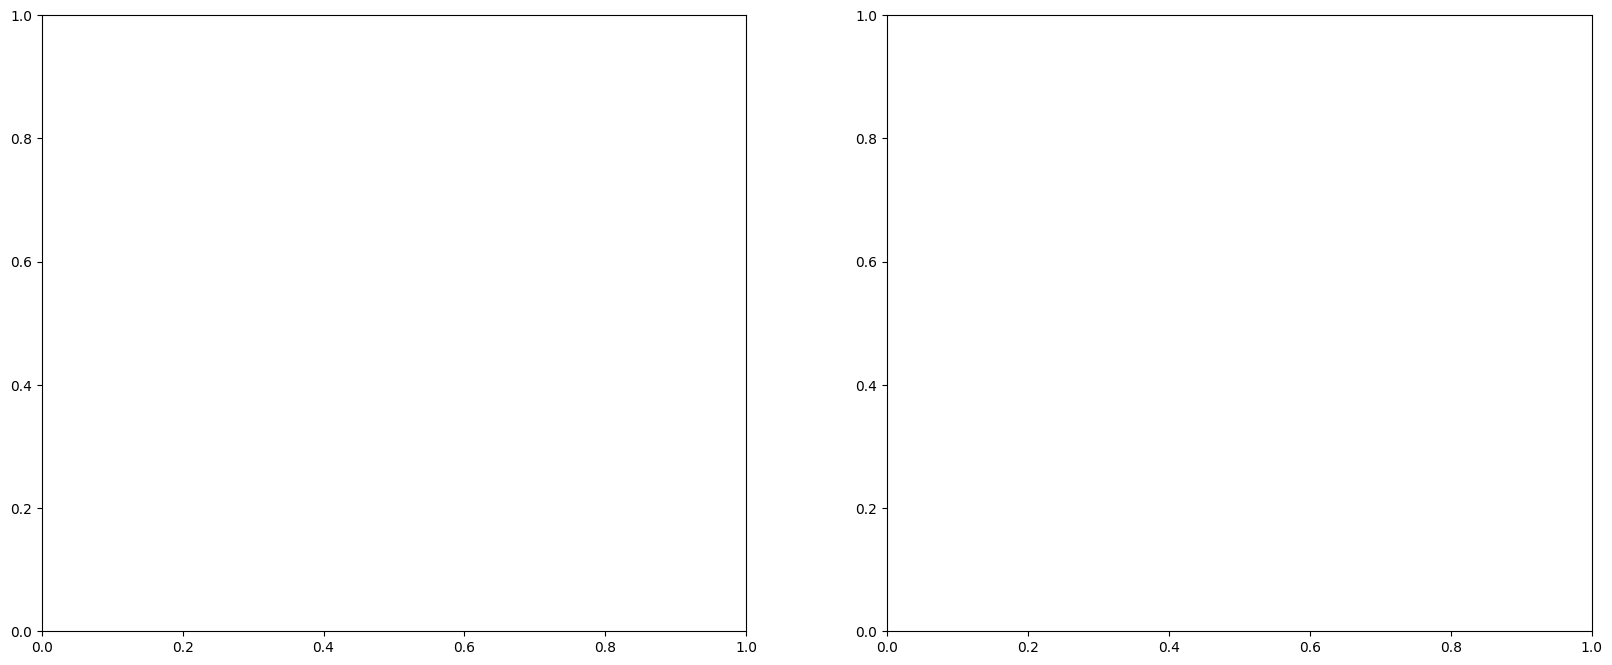

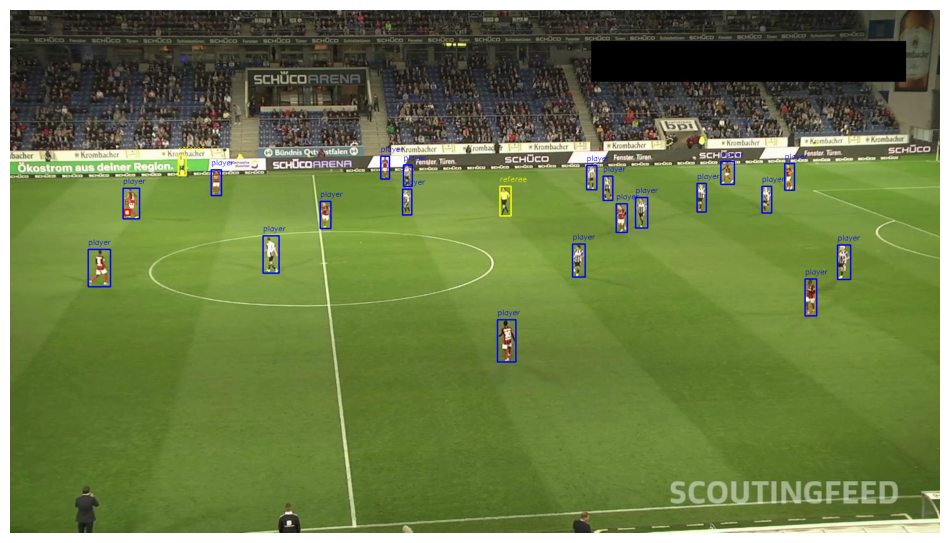

<Figure size 640x480 with 0 Axes>

In [17]:
# Test on sample images with ground truth comparison
test_samples = random.sample(val_images, min(3, len(val_images)))

for test_img in test_samples:
    # Load ground truth annotations
    label_path = DATA_DIR / 'valid' / 'labels' / (test_img.stem + '.txt')
    gt_annotations = load_annotations(label_path)

    # Count ground truth objects by class
    gt_counts = {i: 0 for i in range(len(class_names))}
    for ann in gt_annotations:
        gt_counts[ann[0]] += 1

    # Run model prediction
    results = model(str(test_img))

    for r in results:
        # Count predicted objects by class
        pred_counts = {i: 0 for i in range(len(class_names))}

        print(f"\n{test_img.name}:")
        print(f"  Ground Truth: {len(gt_annotations)} objects")
        print(f"  Predicted: {len(r.boxes)} objects")

        # Print predictions
        if len(r.boxes) > 0:
            for box in r.boxes:
                class_id = int(box.cls)
                confidence = float(box.conf)
                pred_counts[class_id] += 1
                print(f"    {class_names[class_id]}: {confidence:.3f}")

        # Compare counts by class
        print("  Comparison (GT vs Pred):")
        for i, class_name in enumerate(class_names):
            if gt_counts[i] > 0 or pred_counts[i] > 0:
                print(f"    {class_name}: {gt_counts[i]} vs {pred_counts[i]}")

        # Create side-by-side visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Ground truth
        if gt_annotations:
            gt_img = visualize_annotations(test_img, gt_annotations, "", class_names)
            ax1.imshow(gt_img)
        else:
            img = cv2.imread(str(test_img))
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title(f"Ground Truth: {test_img.name}")
        ax1.axis('off')

        # Predictions
        annotated = r.plot()
        ax2.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Predictions: {test_img.name}")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()


In [16]:
# Save the trained model
model_path = Path('models') / 'football_yolo_model.pt'
model_path.parent.mkdir(exist_ok=True)

model.save(str(model_path))
print(f"Model saved: {model_path}")
print(f"Model size: {model_path.stat().st_size / (1024*1024):.1f} MB")

# Export formats for deployment
try:
    onnx_path = model.export(format='onnx')
    print(f"ONNX export: {onnx_path}")
except Exception as e:
    print(f"ONNX export failed: {e}")

print("\n=== Training Complete ===")
print(f"Final mAP@0.5: {val_results.box.map50:.4f}")
print(f"Model ready for football tracking!")

Model saved: models/football_yolo_model.pt
Model size: 12.3 MB
Ultralytics YOLOv8.2.31 🚀 Python-3.12.10 torch-2.3.1 MPS (Apple M4)

PyTorch: starting from '/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

ONNX: starting export with onnx 1.19.0 opset 17...
ONNX: export success ✅ 0.6s, saved as '/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train2/weights/best.onnx' (11.7 MB)

Export complete (1.2s)
Results saved to /Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train2/weights
Predict:         yolo predict task=detect model=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train2/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/Users/alanpehz/Documents/Personal/True Computer Vision/FootballTracker/runs/detect/train2/